# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [13]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [3]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

Accuracy:  0.723
Precision: 0.733
Recall:    0.678


<Figure size 640x480 with 0 Axes>

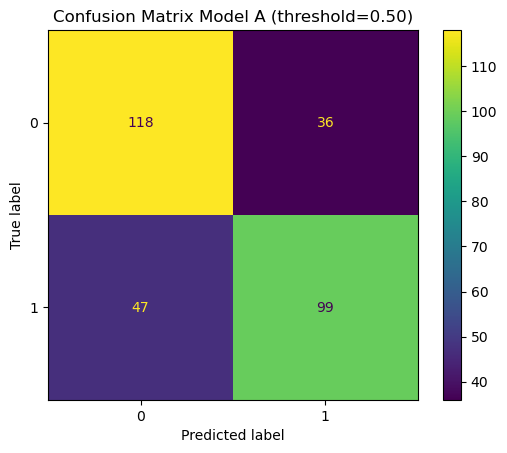

Accuracy:  0.717
Precision: 0.736
Recall:    0.651


<Figure size 640x480 with 0 Axes>

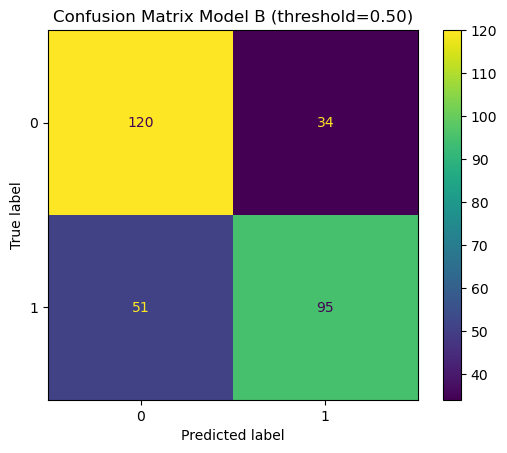

In [15]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# Compute Accuracy, Precision, Recall for both models at threshold 0.5
acc = accuracy_score(yf_test, ypred_full)
prec = precision_score(yf_test, ypred_full, zero_division=0)
rec = recall_score(yf_test, ypred_full, zero_division=0)

print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}")

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(yf_test, ypred_full)
plt.title(f"Confusion Matrix Model A (threshold={thr:.2f})")
plt.show()

acc = accuracy_score(yr_test, ypred_reduced)
prec = precision_score(yr_test, ypred_reduced, zero_division=0)
rec = recall_score(yr_test, ypred_reduced, zero_division=0)

print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}")

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(yr_test, ypred_reduced)
plt.title(f"Confusion Matrix Model B (threshold={thr:.2f})")
plt.show()

## 4) Plot ROC and Precision–Recall Curves

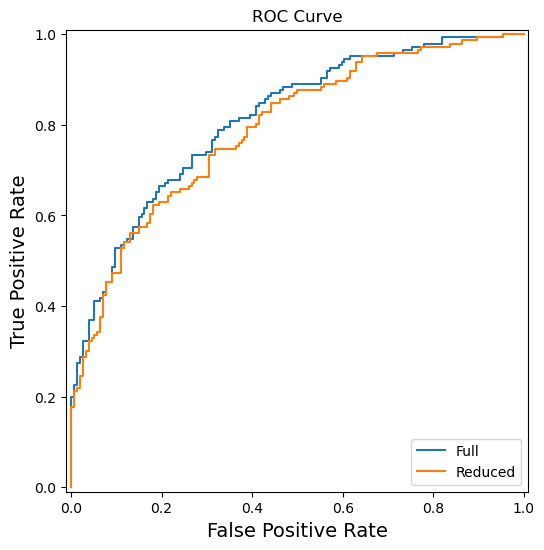

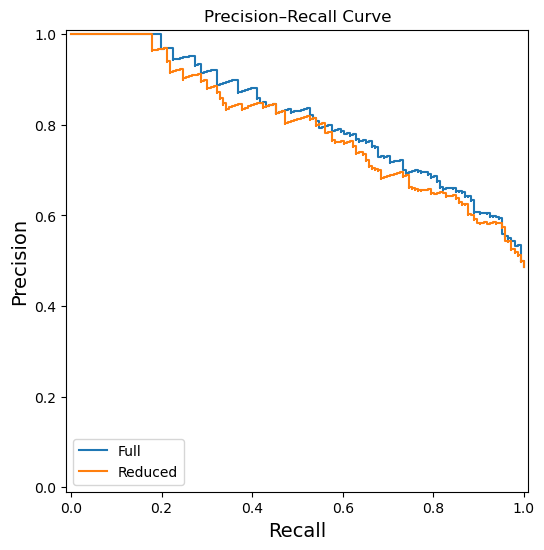

In [11]:
# Plot ROC and PR curves for both models on shared axes

# ROC
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(yf_test, yprob_full, label='Full', ax=ax)
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, label='Reduced', ax=ax)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
plt.title("ROC Curve")
plt.show()

# PR
fig, ax = plt.subplots(figsize=(6,6))
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, label='Full', ax=ax)
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, label='Reduced', ax=ax) 
ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
plt.title("Precision–Recall Curve")
plt.show()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1) The full model has higher ROC_AUC and PR_AUC. This potentially implies that precipitable water is an important factor to consider in these types of models. Intuitively, this makes sense given that CAPE is a measure of instability, but precipitable water is needed for CAPE to realize the convection.
2) For maximum event detection, I would use the full model because it has a higher recall value. For minimizing false alarm rates, I would use the reduced model because it has the highest precision rate. It makes sense that precision is higher for the reduced model but accuracy is higher for the full model. For accuracy, having more variables might be better at realizing the more marginal cases, whereas the reduced model migh be better at realizing simple severe weather environments. 